## Function definitions

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import MultiTaskLassoCV
import os
from matplotlib.lines import Line2D
from itertools import product
import gc
from xml.etree.ElementInclude import include


def load_spectra_sequence(t_start, t_end, dir_path):
    """Load complex spectra using fixed-width field parsing."""
    U = []
    for t in range(t_start, t_end):
        filename = f'{dir_path}/spectr_complex.{t:010d}.txt'
        with open(filename, 'r') as f:
            data = []
            for line in f:
                try:
                    # Extract fixed-width columns
                    real = float(line[13:39])    # From char 14 to 39
                    imag = float(line[39:])      # From char 40 to end
                    data.append(real + 1j * imag)
                except ValueError as e:
                    print(f"Failed to parse line in {filename}: {line.strip()}")
                    raise e
            U.append(np.array(data))
    return np.array(U)


def load_forcing_sequence(t_start, t_end, dir_path):
    """Load complex forcing data using fixed-width parsing."""
    F = []
    for t in range(t_start, t_end):
        filename = f'{dir_path}/forcing_complex.{t:010d}.txt'
        with open(filename, 'r') as f:
            data = []
            for line in f:
                try:
                    real = float(line[13:39])    # From char 14 to 39
                    imag = float(line[39:])      # From char 40 to end
                    data.append(real + 1j * imag)
                except ValueError as e:
                    print(f"Failed to parse line in {filename}: {line.strip()}")
                    raise e
            F.append(np.array(data))
    return np.array(F)


def compute_derivatives(U, dt):
    """Compute time derivatives using finite differences.
    
    Dimensions:
        Input:
            U: array[n_timesteps, nn]
            dt: scalar
        Output:
            dUdt: array[n_timesteps-1, nn]
    """
    return (U[1:] - U[:-1]) / dt


def fit_models_for_shell_config(data_slices, shell_idx, subtract_dissipation, normalize_by_k,
    t_start_list, dt, nu, k, 
    forcing_path, use_all_interactions, include_i, use_lassoCV, lambda_reg, coupled=False):
    """Fit models for a specific shell and configuration using pre-loaded data.
    
    Args:
        coupled: bool - If True, learn all shells together with shared matrix W
        Other args same as before
    """
    W_list = []
    lambda_list = []

    for t_start_curr in t_start_list:
        U_slice, forcing_slice = data_slices[t_start_curr]

        # Build regression system directly without reloading data
        # For coupled learning, set shell_idx to None to learn all shells
        shell_param = None if coupled else shell_idx
        
        X, y = build_regression_system(
            U_slice, dt, nu, k=k, forcing=forcing_slice,
            use_all_interactions=use_all_interactions, shell_idx=shell_param, include_i=include_i,
            subtract_dissipation=subtract_dissipation, normalize_by_k=normalize_by_k
        )

        # Fit model
        if use_lassoCV:
            from sklearn.linear_model import LassoCV
            lasso_cv = LassoCV(cv=5, max_iter=100000)
            lasso_cv.fit(X, y)
            W = lasso_cv.coef_.reshape(1, -1)
            selected_lambda = lasso_cv.alpha_
            lambda_list.append(selected_lambda)
        else:
            from sklearn.linear_model import Lasso
            lasso = Lasso(alpha=lambda_reg, fit_intercept=False, max_iter=100000)
            lasso.fit(X, y)
            W = lasso.coef_.reshape(1, -1)
            lambda_list.append(lambda_reg)

        W_list.append(W)

    return W_list, lambda_list


def save_results(W_list, lambda_list, shell_idx, subtract_dissipation, normalize_by_k, t_start, save_path_W, save_path_lambda, label_list, use_lassoCV, lambda_reg, coupled=False):
    """Save results with consistent naming.
    
    Args:
        coupled: bool - If True, indicates coupled learning was used
        Other args same as before
    """
    # Generate filenames
    coupled_str = "_coupled" if coupled else ""
    shell_str = "all" if coupled else str(shell_idx + 1)
    
    base_params = f"tstart{t_start}_shell{shell_str}_nn20_lambda{(lambda_reg if not use_lassoCV else '')}_lassoCV{use_lassoCV}_subtractD{subtract_dissipation}_knorm{normalize_by_k}{coupled_str}"

    filename_W = f"W_list_{base_params}.npy"
    filename_labels = f"label_list_{base_params}.npy"
    filename_lambda = f"lambda_list_{base_params}.npy"

    # Save arrays
    np.save(os.path.join(save_path_W, filename_W), np.array(W_list, dtype=object))
    np.save(os.path.join(save_path_W, filename_labels), label_list)
    np.save(os.path.join(save_path_lambda, filename_lambda), np.array(lambda_list, dtype=object))


def load_all_data_once(t_start_min, t_end, spectra_path, forcing_path=None, t_start_list=None, 
                      batch_mode=False, n_batches=None, random_batches=False):
    """
    Load all data once and return structured dictionary. Can operate in three modes:
    1. Traditional mode (batch_mode=False): Slice data according to t_start_list
    2. Sequential batch mode (batch_mode=True, random_batches=False): Divide data into n_batches equal sized chunks
    3. Random batch mode (batch_mode=True, random_batches=True): Divide data into n_batches random chunks

    Args:
        t_start_min: minimum start time
        t_end: end time
        spectra_path: path to spectra data
        forcing_path: path to forcing data (optional)
        t_start_list: list of start times (required if batch_mode=False)
        batch_mode: bool, whether to use batch mode
        n_batches: int, number of batches (required if batch_mode=True)
        random_batches: bool, whether to create random batches instead of sequential ones

    Returns:
        dict: Dictionary mapping start indices to (U_slice, forcing_slice) tuples
    """
    print("Loading all data once...")

    # Load full spectra data
    U_full = load_spectra_sequence(t_start_min, t_end, spectra_path)
    print(f"Loaded spectra with shape {U_full.shape}")

    # Load forcing data if provided
    forcing_full = None
    if forcing_path:
        forcing_full = load_forcing_sequence(t_start_min, t_end, forcing_path)
        print(f"Loaded forcing with shape {forcing_full.shape}")

    data_slices = {}

    if batch_mode:
        if n_batches is None:
            raise ValueError("n_batches must be provided when batch_mode=True")

        total_timesteps = U_full.shape[0]
        
        if random_batches:
            # Create random indices for batches
            all_indices = np.arange(total_timesteps)
            np.random.shuffle(all_indices)
            batch_indices = np.array_split(all_indices, n_batches)
            
            # Create slices for each random batch
            for i, indices in enumerate(batch_indices):
                # Sort indices within each batch to maintain temporal coherence
                indices.sort()
                
                U_slice = U_full[indices]
                forcing_slice = forcing_full[indices] if forcing_full is not None else None
                
                # Use first index of batch as key
                start_time = indices[0] + t_start_min
                data_slices[start_time] = (U_slice, forcing_slice)
                
        else:
            # Sequential batches
            batch_size = total_timesteps // n_batches
            
            # Create sequential slices for each batch
            for i in range(n_batches):
                start_idx = i * batch_size
                # For last batch, include any remaining timesteps
                end_idx = total_timesteps if i == n_batches-1 else (i + 1) * batch_size
                
                U_slice = U_full[start_idx:end_idx]
                forcing_slice = forcing_full[start_idx:end_idx] if forcing_full is not None else None
                
                # Use start index as key
                data_slices[start_idx + t_start_min] = (U_slice, forcing_slice)

    else:
        if t_start_list is None:
            raise ValueError("t_start_list must be provided when batch_mode=False")

        # Traditional mode: Pre-slice data for each t_start
        for t_start_curr in t_start_list:
            start_idx = t_start_curr - t_start_min
            U_slice = U_full[start_idx:]
            forcing_slice = forcing_full[start_idx:] if forcing_full is not None else None
            data_slices[t_start_curr] = (U_slice, forcing_slice)

    return data_slices


def build_complete_dictionary(U, use_all_interactions=False, include_i=False, include_dissipation=False, 
                            k=None, nu=None, normalize_by_k=False, target_shells=None):
    """Build dictionary of nonlinear interaction terms with optional imaginary unit multiplication and dissipation terms.

    Args:
        U: array[n_timesteps, nn] -- input complex time series
        use_all_interactions: bool -- whether to include conjugate variants
        include_i: bool -- whether to multiply all features by the imaginary unit i
        include_dissipation: bool -- whether to include dissipation terms in the dictionary
        k: array[nn] -- wavenumbers (required if include_dissipation=True or normalize_by_k=True)
        nu: float -- viscosity (required if include_dissipation=True)
        normalize_by_k: bool -- whether to normalize each equation by its corresponding k_n
        target_shells: list or None -- shells being learned (for normalization)

    Returns:
        Phi: array[n_timesteps, n_features] -- dictionary matrix
    """
    n_timesteps, nn = U.shape
    n_base = nn * nn
    n_types = 4 if use_all_interactions else 1
    n_features = n_base * n_types
    
    # Add dissipation features if requested
    if include_dissipation:
        if k is None or nu is None:
            raise ValueError("k and nu must be provided when include_dissipation=True")
        n_features += nn  # Add nn dissipation terms
    
    if normalize_by_k and k is None:
        raise ValueError("k must be provided when normalize_by_k=True")
    
    Phi = np.zeros((n_timesteps, n_features), dtype=complex)
    idx = 0
    factor = 1j if include_i else 1.0

    # Nonlinear interaction terms
    for i in range(nn):
        for j in range(nn):
            Phi[:, idx] = factor * U[:, i] * U[:, j]
            idx += 1
            if use_all_interactions:
                Phi[:, idx] = factor * U[:, i] * np.conj(U[:, j])
                idx += 1
                Phi[:, idx] = factor * np.conj(U[:, i]) * U[:, j]
                idx += 1
                Phi[:, idx] = factor * np.conj(U[:, i]) * np.conj(U[:, j])
                idx += 1
    
    # Dissipation terms
    if include_dissipation:
        for i in range(nn):
            #Phi[:, idx] = -nu * k[i]**2 * U[:, i]  # Negative because we move it to RHS
            Phi[:, idx] =  U[:, i]  # Negative because we move it to RHS
            idx += 1

    return Phi


def build_regression_system(U, dt, nu, k, forcing=None, use_all_interactions=False, 
                          shell_idx=None, include_i=True, subtract_dissipation=True,
                          normalize_by_k=False):
    """Build regression system for real and imaginary parts with optional equation normalization.
    
    Args:
        U: array[n_timesteps, nn] (complex)
        dt, nu: scalars
        k: array[nn]
        forcing: array[n_timesteps, nn] (complex) or None
        use_all_interactions: bool
        shell_idx: int or None -- if None, learn all shells; if int, learn only that shell
        include_i: bool
        subtract_dissipation: bool -- if True, subtract dissipation from target; if False, include in dictionary
        normalize_by_k: bool -- if True, normalize each equation by its corresponding k_n
        
    Returns:
        X: array[n_equations, n_features]  # Stacked real/imag for selected shells
        y: array[n_equations]              # Stacked real/imag for selected shells
    """
    n_timesteps, nn = U.shape
    
    # Compute derivatives
    dUdt = compute_derivatives(U, dt)  # Shape: [n_timesteps-1, nn]
    
    # Determine which shells to learn
    if shell_idx is None:
        # Learn all shells
        target_shells = list(range(nn))
        n_equations_per_shell = n_timesteps - 1
        total_equations = n_equations_per_shell * nn * 2  # *2 for real/imag
    else:
        # Learn single shell
        target_shells = [shell_idx]
        n_equations_per_shell = n_timesteps - 1
        total_equations = n_equations_per_shell * 2  # *2 for real/imag
    
    # Build dictionary (always use all U data for interactions)
    include_dissipation = not subtract_dissipation
    Phi = build_complete_dictionary(U[:-1], use_all_interactions=use_all_interactions, 
                                  include_i=include_i, include_dissipation=include_dissipation,
                                  k=k, nu=nu, normalize_by_k=normalize_by_k, 
                                  target_shells=target_shells)

    
    # Prepare target variables and apply normalization
    y_list = []
    Phi_list = []
    
    for shell in target_shells:
        y_shell = dUdt[:, shell]
        
        # Optionally subtract dissipation
        if subtract_dissipation:
            y_shell = y_shell + nu * k[shell]**2 * U[:-1, shell]
        
        # Subtract forcing if provided
        if forcing is not None:
            y_shell = y_shell - forcing[:-1, shell]
        
        # Apply normalization by k_n if requested
        if normalize_by_k:
            y_shell = y_shell / k[shell]
            # Also normalize the corresponding dictionary entries
            Phi_normalized = Phi / k[shell]
            Phi_list.append(Phi_normalized)
        else:
            Phi_list.append(Phi)
        
        y_list.append(y_shell)
    
    # Stack real and imaginary parts
    if shell_idx is None:
        # Multi-shell case: create block structure
        X = np.zeros((total_equations, Phi.shape[1]), dtype=float)
        y = np.zeros(total_equations, dtype=float)
        
        for i, shell in enumerate(target_shells):
            # Get the appropriate Phi for this shell
            Phi_shell = Phi_list[i]
            
            # Real part
            start_idx = i * n_equations_per_shell * 2
            end_idx = start_idx + n_equations_per_shell
            X[start_idx:end_idx, :] = Phi_shell.real
            y[start_idx:end_idx] = y_list[i].real
            
            # Imaginary part
            start_idx = end_idx
            end_idx = start_idx + n_equations_per_shell
            X[start_idx:end_idx, :] = Phi_shell.imag
            y[start_idx:end_idx] = y_list[i].imag
    else:
        # Single shell case
        Phi_shell = Phi_list[0]
        X = np.vstack([Phi_shell.real, Phi_shell.imag])
        y = np.concatenate([y_list[0].real, y_list[0].imag])
    
    return X, y




def plot_interaction_heatmap(W_list, label_list, nn, use_all_interactions, expected_interactions, shell_idx,
    xlabel="Lambda", top_n=20, top_n_start=None, top_n_end=None,
    cmap='viridis', use_lassoCV=False, lambda_reg=5e2,
    subtract_dissipation=True, normalize_by_k=False,
    threshold=1e-5, coupled=False):
    """
    Plot heatmap of top interactions, using top_n_start from first W and top_n_end from last W.
    Also plot number of significant interactions for each step.
    Highlight y-labels in green if they are expected interactions.
    Visually separate top_n_start and top_n_end in the heatmap.
    
    Args:
        normalize_by_k: bool -- whether the models were trained with k-normalization
        coupled: bool -- whether the models were trained with coupled learning
        ... (other args same as before)
    """
    # Analyze all interactions for each W
    sig_list = [
        analyze_interactions(W, nn, use_all_interactions=use_all_interactions,
                           expected_interactions=expected_interactions, shell_idx=shell_idx,
                           include_dissipation=not subtract_dissipation, threshold=threshold,
                           coupled=coupled)
        for W in W_list
    ]

    # Get top_n_start from first, top_n_end from last
    if top_n_start is None:
        top_n_start = top_n
    if top_n_end is None:
        top_n_end = top_n

    def get_top_keys(sig, n):
        sorted_sig = sorted(sig, key=lambda s: abs(s['weight']), reverse=True)
        keys = []
        for s in sorted_sig[:n]:
            if s['term_type'] == 'dissipation':
                # Use consistent key format: ('D', shell_index, 'dissipation')
                keys.append(('D', s['i']-1, 'dissipation'))  # Convert back to 0-based
            else:
                keys.append((s['i']-1, s['j']-1, s['type']))  # Convert back to 0-based
        return keys

    keys_start = get_top_keys(sig_list[0], top_n_start)
    keys_end = get_top_keys(sig_list[-1], top_n_end)
    
    # Combine keys while preserving order and avoiding duplicates
    sorted_keys = []
    seen = set()
    for k in keys_start + keys_end:
        if k not in seen:
            sorted_keys.append(k)
            seen.add(k)
        if len(sorted_keys) >= top_n:
            sorted_keys = sorted_keys[:top_n]
            break
    
    print(f"Debug: Found {len(sorted_keys)} unique interactions")
    print(f"First few keys: {sorted_keys[:5]}")
    
    # Create interaction names for plotting
    interaction_names = []
    for key in sorted_keys:
        if key[0] == 'D' and key[2] == 'dissipation':
            interaction_names.append(f"D{key[1]+1}")  # Convert back to 1-based for display
        else:
            interaction_names.append(f"{key[0]+1}-{key[1]+1}:{key[2]}")  # Convert back to 1-based
    
    interaction_index = {k: idx for idx, k in enumerate(sorted_keys)}

    # Build heatmap
    heat = np.zeros((len(sorted_keys), len(W_list)))
    for col, sig in enumerate(sig_list):
        for s in sig:
            if s['term_type'] == 'dissipation':
                key = ('D', s['i']-1, 'dissipation')  # Consistent key format
            else:
                key = (s['i']-1, s['j']-1, s['type'])
                
            if key in interaction_index:
                row = interaction_index[key]
                heat[row, col] = abs(s['weight'])

    # Debug: Check if dissipation terms are being found
    dissipation_rows = [i for i, key in enumerate(sorted_keys) if key[0] == 'D']
    print(f"Debug: Dissipation rows in heatmap: {dissipation_rows}")
    if dissipation_rows:
        print(f"Debug: Dissipation values in first column: {heat[dissipation_rows, 0]}")

    # Row-wise normalization for better visualization
    row_max = np.max(heat, axis=1, keepdims=True)
    # Avoid division by zero
    row_max[row_max == 0] = 1
    heat_norm = heat / row_max

    # Determine which y-labels are expected (now handles all shells for coupled learning)
    is_expected = []
    for key in sorted_keys:
        if key[0] == 'D' and key[2] == 'dissipation':
            # For dissipation terms, check if it's expected for any shell when coupled
            if coupled:
                # In coupled learning, dissipation from any shell could be relevant
                is_expected.append(True)  # or use more sophisticated logic
            else:
                is_expected.append(key[1] == shell_idx if shell_idx is not None else False)
        else:
            i, j, t = key
            # Check if this interaction is expected for any shell
            expected_anywhere = False
            if coupled and expected_interactions:
                # Check all shells for coupled learning
                for shell_n in range(nn):
                    expected_set = expected_interactions.get(shell_n, set())
                    if ((i, j, t) in expected_set) or ((j, i, t) in expected_set):
                        expected_anywhere = True
                        break
            elif not coupled and expected_interactions and shell_idx is not None:
                # Original single shell logic
                expected_set = expected_interactions.get(shell_idx, set())
                expected_anywhere = ((i, j, t) in expected_set) or ((j, i, t) in expected_set)
            
            is_expected.append(expected_anywhere)

    # Plot normalized heatmap
    plt.figure(figsize=(12, max(6, len(interaction_names)*0.25)))
    im = plt.imshow(heat_norm, aspect='auto', cmap=cmap, origin='lower', vmin=0, vmax=1)
    plt.colorbar(im, label='|Coefficient| (row-normalized)')
    plt.xlabel(xlabel)
    plt.ylabel("Interaction (i-j:type or D#)")
    
    title_suffix = " (k-normalized)" if normalize_by_k else ""
    coupled_suffix = " (coupled)" if coupled else ""
    if shell_idx is not None and not coupled:
        plt.title(f"Top Interactions Heatmap — Shell {shell_idx+1}{title_suffix}{coupled_suffix}")
    else:
        plt.title(f"Top Interactions Heatmap — All Shells{title_suffix}{coupled_suffix}")

    # Custom y-tick labels with color
    ax = plt.gca()
    yticks = np.arange(len(interaction_names))
    ax.set_yticks(yticks)
    ax.set_yticklabels(interaction_names)
    
    # Color the y-tick labels
    for idx, (label, expected) in enumerate(zip(interaction_names, is_expected)):
        color = 'green' if expected else 'red' if label.startswith('D') else 'black'
        ax.get_yticklabels()[idx].set_color(color)

    # Mark separation between top_n_start and top_n_end
    sep = len([k for k in keys_start if k in sorted_keys])
    if sep < len(sorted_keys) and sep > 0:
        ax.axhline(sep-0.5, color='cyan', linestyle='--', linewidth=2, label='Top_n_start/top_n_end boundary')
        ax.legend(loc='upper right')

    plt.xticks(range(len(label_list)), label_list, rotation=45)
    plt.tight_layout()
    
    # Create save directory if it doesn't exist
    import os
    save_path = "Nonlinear_reg_figures"
    os.makedirs(save_path, exist_ok=True)
    coupled_str = "_coupled" if coupled else ""
    filename = f"interaction_heatmap_top_n_start{top_n_start}_top_n_end{top_n_end}_cmap{cmap}_nn{nn}_shell{shell_idx}_xaxis{len(label_list)}_lambda{(lambda_reg if not use_lassoCV else '')}_lassoCV{use_lassoCV}_subtractD{subtract_dissipation}_knorm{normalize_by_k}{coupled_str}.png"
    plt.savefig(os.path.join(save_path, filename))
    plt.close()

    # Plot number of significant interactions for each step
    sig_counts = [sum(abs(s['weight']) > 1e-5 for s in sig) for sig in sig_list]
    plt.figure(figsize=(8, 4))
    plt.plot(label_list, sig_counts, marker='o')
    plt.axhline(y=3, color='red', linestyle='--', linewidth=1.5, label='y=3')
    plt.xlabel(xlabel)
    plt.ylabel("Number of significant interactions")
    title_suffix = " (k-normalized)" if normalize_by_k else ""
    coupled_suffix = " (coupled)" if coupled else ""
    plt.title(f"Number of significant interactions per step{title_suffix}{coupled_suffix}")
    plt.legend()
    plt.xticks(range(len(label_list)), label_list, rotation=45)
    plt.tight_layout()
    
    filename = f"sig_interactions_count_nn{nn}_shell{shell_idx}_xaxis{len(label_list)}_lambda{(lambda_reg if not use_lassoCV else '')}_lassoCV{use_lassoCV}_subtractD{subtract_dissipation}_knorm{normalize_by_k}{coupled_str}.png"
    plt.savefig(os.path.join(save_path, filename))
    plt.close()

    return heat, interaction_names, sorted_keys


def analyze_interactions(W, nn, use_all_interactions=False, threshold=1e-5, expected_interactions=None, 
                        shell_idx=None, include_dissipation=False, coupled=False):
    """Analyze significant interactions in the learned model.
    
    Args:
        W: array[n_shells, n_features] or array[1, n_features] - Learned coefficients
        nn: int - Number of shells
        use_all_interactions: bool
        threshold: float
        expected_interactions: dict
        shell_idx: int or None - The shell being analyzed (0-based) or None for all shells
        include_dissipation: bool - Whether dissipation terms are included in the dictionary
        coupled: bool - If True, W contains coefficients for all shells learned together
    """
    significant = []
    types = ['regular', 'j_conj', 'i_conj', 'both_conj'] if use_all_interactions else ['regular']
    
    # Convert to 2D array if needed
    Wmat = W if W.ndim == 2 else W.reshape(1, -1)
    n_shells_learned = Wmat.shape[0]
    
    if coupled:
        # For coupled learning, W has shape [1, n_features] but represents all shells
        # Each shell's equation uses the same feature vector
        target_shells = list(range(nn))
        shell_indices = [0] * nn  # All shells use the same row in Wmat
    else:
        # Original uncoupled logic
        if shell_idx is not None:
            target_shells = [shell_idx]
            shell_indices = [0]  # Index in Wmat
        else:
            target_shells = list(range(min(n_shells_learned, nn)))
            shell_indices = list(range(n_shells_learned))
    
    for shell_w_idx, target_shell in zip(shell_indices, target_shells):
        # Analyze interaction terms
        for i in range(nn):
            for j in range(nn):
                for t, type_name in enumerate(types):
                    idx = (i * nn + j) * (4 if use_all_interactions else 1) + t
                    if idx >= Wmat.shape[1]:
                        continue
                        
                    weight = Wmat[shell_w_idx, idx]
                    if abs(weight) <= threshold:
                        continue
                    
                    # Check if interaction is expected for the target shell
                    key = (i, j, type_name)
                    expected_set = expected_interactions.get(target_shell, set()) if expected_interactions else set()
                    status = 'expected' if key in expected_set else 'unexpected'
                    
                    significant.append({
                        'target': target_shell + 1,  # Convert to 1-based indexing
                        'i': i + 1,
                        'j': j + 1,
                        'type': type_name,
                        'weight': weight,
                        'highlight': status == 'expected',
                        'status': status,
                        'term_type': 'interaction'
                    })
        
        # Analyze dissipation terms if included
        if include_dissipation:
            dissipation_start_idx = nn * nn * (4 if use_all_interactions else 1)
            for i in range(nn):
                idx = dissipation_start_idx + i
                if idx >= Wmat.shape[1]:
                    continue
                    
                weight = Wmat[shell_w_idx, idx]
                if abs(weight) <= threshold:
                    continue
                
                significant.append({
                    'target': target_shell + 1,
                    'i': i + 1,
                    'j': i + 1,  # Self-interaction
                    'type': 'dissipation',
                    'weight': weight,
                    'highlight': (i == target_shell),  # Highlight if dissipation comes from the target shell
                    'status': 'expected' if (i == target_shell) else 'unexpected',
                    'term_type': 'dissipation'
                })
    
    return significant


def plot_coupled_results(W, nn, use_all_interactions=False, include_dissipation=False, 
                        top_n=20, threshold=1e-5, output_dir="Nonlinear_reg_figures", 
                        save_plots=True, plot_suffix="coupled", impose_symmetry=True,
                        expected_shells=None):
    """
    Plot results for coupled optimization similar to _plot_independent_results.
    Creates a visualization showing the top_n interactions and dissipation terms
    from a single weight matrix W, with expected interactions highlighted.
    
    Args:
        W: array[1, n_features] - Single weight matrix from coupled learning
        nn: int - Number of shells
        use_all_interactions: bool - Whether all interaction types were used
        include_dissipation: bool - Whether dissipation terms are included
        top_n: int - Number of top interactions to visualize
        threshold: float - Threshold for significant interactions  
        output_dir: str - Directory to save plots
        save_plots: bool - Whether to save the plots
        plot_suffix: str - Suffix for plot filename
        impose_symmetry: bool - Whether to impose symmetry on interactions
        expected_shells: list - List of shell indices used to construct W (0-based)
                               If None, uses all shells 0 to nn-1
    """

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    # Ensure W is 2D
    Wmat = W if W.ndim == 2 else W.reshape(1, -1)
    
    # Get expected interactions for highlighting
    if expected_shells is None:
        expected_shells = list(range(nn))
    expected_interactions = get_expected_interactions_for_shells(nn, expected_shells)
    
    # Get all significant interactions
    types = ['regular', 'j_conj', 'i_conj', 'both_conj'] if use_all_interactions else ['regular']
    all_interactions = []
    interaction_dict = {}  # To avoid duplicates and handle symmetry properly
    
    # Extract interaction terms
    for i in range(nn):
        for j in range(nn):
            for t, type_name in enumerate(types):
                idx = (i * nn + j) * (4 if use_all_interactions else 1) + t
                if idx >= Wmat.shape[1]:
                    continue
                    
                weight = Wmat[0, idx]
                if abs(weight) > threshold:
                    # Create unique key for this interaction
                    key = (i+1, j+1, type_name)
                    interaction_dict[key] = weight
                    
                    # Handle symmetry by finding symmetric counterpart
                    if impose_symmetry:
                        sym_key = get_symmetric_interaction(i+1, j+1, type_name)
                        if sym_key and sym_key not in interaction_dict:
                            # Check if symmetric interaction exists in weight matrix
                            sym_i, sym_j, sym_type = sym_key
                            sym_t = types.index(sym_type) if sym_type in types else -1
                            if sym_t >= 0:
                                sym_idx = ((sym_i-1) * nn + (sym_j-1)) * (4 if use_all_interactions else 1) + sym_t
                                if sym_idx < Wmat.shape[1]:
                                    sym_weight = Wmat[0, sym_idx]
                                    # Always add symmetric term, even if below threshold
                                    if abs(sym_weight) > threshold:
                                        interaction_dict[sym_key] = sym_weight
                                    else:
                                        # Use the same weight for symmetry (force symmetry)
                                        interaction_dict[sym_key] = weight
                                else:
                                    # Index out of bounds, force symmetry with same weight
                                    interaction_dict[sym_key] = weight
                            else:
                                # Type not available, force symmetry with same weight
                                interaction_dict[sym_key] = weight
    
    # Convert dictionary to list
    for (i, j, type_name), weight in interaction_dict.items():
        is_expected = (i-1, j-1, type_name) in expected_interactions
        all_interactions.append({
            'i': i-1, 'j': j-1, 'type': type_name, 'weight': weight,
            'term_type': 'interaction', 'abs_weight': abs(weight),
            'is_expected': is_expected
        })
        
    # Extract dissipation terms if included
    all_dissipations = []
    if include_dissipation:
        dissipation_start_idx = nn * nn * (4 if use_all_interactions else 1)
        for i in range(nn):
            idx = dissipation_start_idx + i
            if idx >= Wmat.shape[1]:
                continue
                
            weight = Wmat[0, idx]
            if abs(weight) > threshold:
                # Check if this dissipation is expected (shell i is in expected_shells)
                is_expected_dissip = i in expected_shells
                all_dissipations.append({
                    'i': i, 'j': i, 'type': 'dissipation', 'weight': weight,
                    'term_type': 'dissipation', 'abs_weight': abs(weight),
                    'is_expected': is_expected_dissip
                })
    
    # Get top interactions and dissipations
    all_interactions.sort(key=lambda x: x['abs_weight'], reverse=True)
    all_dissipations.sort(key=lambda x: x['abs_weight'], reverse=True)
    
    top_interactions = all_interactions[:top_n]
    top_dissipations = all_dissipations[:top_n]
    
    # Create masks for visualization
    interaction_mask = np.zeros((nn, nn))
    expected_mask = np.zeros((nn, nn), dtype=bool)
    dissipation_mask = np.zeros(nn)
    expected_dissip_mask = np.zeros(nn, dtype=bool)
    
    # Fill interaction mask with binary values
    if top_interactions:
        for item in top_interactions:
            interaction_mask[item['i'], item['j']] = 1.0
            if item['is_expected']:
                expected_mask[item['i'], item['j']] = True
    
    # Fill dissipation mask with binary values  
    if top_dissipations:
        for item in top_dissipations:
            dissipation_mask[item['i']] = 1.0
            if item['is_expected']:
                expected_dissip_mask[item['i']] = True
    
    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    fig.suptitle(f'Top {top_n} Terms (Expected interactions highlighted)', fontsize=14)
    
    # Plot interaction mask in blues
    im1 = ax.imshow(interaction_mask, cmap='Blues', aspect='auto', alpha=0.7, vmin=0, vmax=1)
    
    # Add dissipation terms in reds if present
    if len(top_dissipations) > 0:
        # Create a diagonal mask for dissipation terms
        dissip_viz = np.zeros((nn, nn))
        np.fill_diagonal(dissip_viz, dissipation_mask)
        
        # Mask out zero values for overlay
        dissip_masked = np.ma.masked_where(dissip_viz == 0, dissip_viz)
        im2 = ax.imshow(dissip_masked, cmap='Reds', aspect='auto', alpha=0.8, vmin=0, vmax=1)
    # Highlight expected interactions with colored borders
    for i in range(nn):
        for j in range(nn):
            if expected_mask[i, j]:
                # Add a thick dashed border around expected interactions
                rect = plt.Rectangle((j-0.45, i-0.45), 0.9, 0.9, 
                                   fill=False, edgecolor='white', linewidth=3, 
                                   linestyle=':', alpha=0.9)
                ax.add_patch(rect)
    
    # Highlight expected dissipations on diagonal
    for i in range(nn):
        if expected_dissip_mask[i]:
            # Add a thick dashed border around expected dissipations
            rect = plt.Rectangle((i-0.45, i-0.45), 0.9, 0.9,
                               fill=False, edgecolor='white', linewidth=3,
                               linestyle=':', alpha=0.9)
            ax.add_patch(rect)
    
    # Set x-axis ticks and labels centered between grid lines 
    ax.set_xlim(-0.5, nn - 0.5)
    ax.set_xticks(range(nn))
    ax.set_xticklabels(range(1, nn + 1))
    ax.set_xticks(np.arange(-0.5, nn), minor=True)

    # Set y-axis ticks and labels centered between grid lines
    ax.set_ylim(nn - 0.5, -0.5)  # Reverse y-axis limits
    ax.set_yticks(range(nn))
    ax.set_yticklabels(range(1, nn + 1))
    ax.set_yticks(np.arange(-0.5, nn), minor=True)
    
    ax.set_xlabel('Shell j')
    ax.set_ylabel('Shell i')
    ax.set_title('Top Interactions (Blue) & Dissipation (Red) Terms\nExpected interactions: white border, Expected dissipations: white border')
    
    # Draw grid lines between values using minor ticks
    ax.grid(True, which='minor', color='gray', linestyle='-', alpha=0.3, linewidth=0.5)
    ax.grid(False, which='major')  # Turn off major grid
    
    # Add dual colorbars
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="3%", pad=0.05)
    cb1 = plt.colorbar(im1, cax=cax1, label='Interactions (present/absent)')
    
    if len(top_dissipations) > 0:
        cax2 = divider.append_axes("right", size="3%", pad=0.75)
        cb2 = plt.colorbar(im2, cax=cax2, label='Dissipation (present/absent)')
    
    plt.tight_layout()
    
    if save_plots:
        os.makedirs(output_dir, exist_ok=True)
        plot_filename = f'grid_top{top_n}_{plot_suffix}.png'
        plt.savefig(os.path.join(output_dir, plot_filename), 
                   dpi=300, bbox_inches='tight')
        plt.close()
    
    # Print summary
    print(f"Top {len(top_interactions)} interactions:")
    for item in top_interactions:
        expected_str = " (EXPECTED)" if item['is_expected'] else ""
        print(f"  Shell {item['i']}-{item['j']} ({item['type']}): {item['weight']:.6f}{expected_str}")
    
    if top_dissipations:
        print(f"\nTop {len(top_dissipations)} dissipations:")
        for item in top_dissipations:
            expected_str = " (EXPECTED)" if item['is_expected'] else ""
            print(f"  Shell {item['i']} (dissipation): {item['weight']:.6f}{expected_str}")
    
    # Print expected interactions summary
    expected_found = sum(1 for item in top_interactions if item['is_expected'])
    expected_dissip_found = sum(1 for item in top_dissipations if item['is_expected'])
    print(f"\nExpected interactions found in top {top_n}: {expected_found}/{len(expected_interactions)}")
    if include_dissipation:
        print(f"Expected dissipations found in top {top_n}: {expected_dissip_found}/{len(expected_shells)}")
    
    return interaction_mask, dissipation_mask, top_interactions, top_dissipations


def get_symmetric_interaction(i, j, type_name):
    """
    Get the symmetric counterpart of an interaction (i, j, type).
    Returns (j, i, symmetric_type) or None if no symmetry applies.
    """
    if type_name == 'regular':
        return (j, i, 'regular')
    elif type_name == 'i_conj':
        return (j, i, 'j_conj')
    elif type_name == 'j_conj':
        return (j, i, 'i_conj')
    elif type_name == 'both_conj':
        return (j, i, 'both_conj')
    else:
        return None


def get_expected_interactions_for_shells(nn, shell_indices):
    """
    Get expected interactions for a list of shell indices.
    
    Args:
        nn: Total number of shells
        shell_indices: List of shell indices (0-based) used to construct W
        
    Returns:
        set: Set of expected (i, j, type) tuples (1-based indexing)
    """
    all_expected = set()
    
    for n in shell_indices:
        # Get expected interactions for shell n (0-based)
        shell_expected = get_expected_interactions_single_shell(nn, n)
        all_expected.update(shell_expected)
    
    return all_expected


def get_expected_interactions_single_shell(nn, n):
    """
    Get expected interactions for a single shell n (0-based indexing).
    Returns interactions with 1-based indexing for consistency with plotting.
    
    The three model terms for shell n are:
    1) i k_{n+1} A u_{n+1}^* u_{n+2}    → (n+2, n+3, 'i_conj') in 1-based
    2) i k_n     B u_{n-1}^* u_{n+1}    → (n, n+2, 'i_conj') in 1-based  
    3) -i k_{n-1} C u_{n-2}   u_{n-1}   → (n-1, n, 'regular') in 1-based
    Plus their symmetric counterparts.
    """
    terms = set()
    
    # Term 1: forward-forward interaction
    if n <= nn-3:
        # (n+1, n+2, 'i_conj') becomes (n+2, n+3, 'i_conj') in 1-based
        terms.add((n+1, n+2, 'i_conj'))
        terms.add((n+2, n+1, 'j_conj'))  # symmetric
    
    # Term 2: backward-forward interaction  
    if 1 <= n <= nn-2:
        # (n-1, n+1, 'i_conj') becomes (n, n+2, 'i_conj') in 1-based
        terms.add((n-1, n+1, 'i_conj'))
        terms.add((n+1, n-1, 'j_conj'))  # symmetric
    
    # Term 3: backward-backward interaction
    if n >= 2:
        # (n-2, n-1, 'regular') becomes (n-1, n, 'regular') in 1-based
        terms.add((n-2, n-1, 'regular'))
        terms.add((n-1, n-2, 'regular'))  # symmetric
    
    return terms


def get_expected_interactions(nn):
    """
    Build a dict of expected (i, j, type) tuples for each shell index n (0-based).
    Updated to return 1-based indexing for consistency.
    """
    expected = {}
    for n in range(nn):
        expected[n] = get_expected_interactions_single_shell(nn, n)
    return expected



def build_feature_mapping(nn, use_all_interactions=False, include_dissipation=False):
    """Build mapping from feature indices to interaction/dissipation descriptions.
    
    Args:
        nn: int -- number of shells
        use_all_interactions: bool -- whether to include conjugate variants
        include_dissipation: bool -- whether to include dissipation terms
        
    Returns:
        dict: mapping from feature_idx to (shell_i, shell_j, interaction_type) or (shell_i, 'dissipation')
    """
    feature_to_interaction = {}
    feature_idx = 0
    
    # Nonlinear interaction terms
    for i in range(nn):
        for j in range(nn):
            feature_to_interaction[feature_idx] = (i, j, 'regular')
            feature_idx += 1
            
            if use_all_interactions:
                feature_to_interaction[feature_idx] = (i, j, 'j_conj')
                feature_idx += 1
                feature_to_interaction[feature_idx] = (i, j, 'i_conj')
                feature_idx += 1
                feature_to_interaction[feature_idx] = (i, j, 'both_conj')
                feature_idx += 1
    
    # Dissipation terms
    if include_dissipation:
        for i in range(nn):
            feature_to_interaction[feature_idx] = (i, 'dissipation')
            feature_idx += 1
    
    return feature_to_interaction


def batch_cross_validation_regression(data_slices, shell_idx, subtract_dissipation, normalize_by_k,
                                    dt, nu, k, forcing_path, use_all_interactions, include_i, 
                                    use_lassoCV, lambda_reg, significance_threshold=1e-6):
    """Perform batch-wise cross-validation regression for a specific shell.
    
    Args:
        data_slices: dict -- output from load_all_data_once with batch_mode=True
        shell_idx: int -- shell to learn
        Other args: same as fit_models_for_shell_config
        significance_threshold: float -- threshold for considering coefficients significant
        
    Returns:
        batch_results: dict with keys:
            'W_list': list of coefficient arrays for each batch
            'lambda_list': list of regularization parameters
            'feature_mapping': dict mapping feature indices to interactions
            'significance_counts': dict counting significant features across batches
            'final_W': single W constructed from shared significant features
    """
    W_list = []
    lambda_list = []
    batch_keys = list(data_slices.keys())
    n_batches = len(batch_keys)
    
    print(f"Running batch cross-validation for shell {shell_idx+1} with {n_batches} batches")
    
    # Process each batch
    for i, batch_key in enumerate(batch_keys):
        print(f"Processing batch {i+1}/{n_batches}")
        
        U_slice, forcing_slice = data_slices[batch_key]
        
        # Build regression system
        X, y = build_regression_system(
            U_slice, dt, nu, k=k, forcing=forcing_slice,
            use_all_interactions=use_all_interactions, shell_idx=shell_idx, include_i=include_i,
            subtract_dissipation=subtract_dissipation, normalize_by_k=normalize_by_k
        )
        
        # Fit model
        if use_lassoCV:
            from sklearn.linear_model import LassoCV
            lasso_cv = LassoCV(cv=5, max_iter=100000)
            lasso_cv.fit(X, y)
            W = lasso_cv.coef_
            selected_lambda = lasso_cv.alpha_
            lambda_list.append(selected_lambda)
        else:
            from sklearn.linear_model import Lasso
            lasso = Lasso(alpha=lambda_reg, fit_intercept=False, max_iter=100000)
            lasso.fit(X, y)
            W = lasso.coef_
            lambda_list.append(lambda_reg)
        
        W_list.append(W)
    
    # Build feature mapping
    nn = k.shape[0]
    include_dissipation = not subtract_dissipation
    feature_mapping = build_feature_mapping(nn, use_all_interactions, include_dissipation)
    
    # Analyze significance across batches
    significance_counts = analyze_feature_significance(W_list, feature_mapping, significance_threshold)
    
    return {
        'W_list': W_list,
        'lambda_list': lambda_list,
        'feature_mapping': feature_mapping,
        'significance_counts': significance_counts,
        'n_batches': n_batches
    }


def analyze_feature_significance(W_list, feature_mapping, significance_threshold=1e-6):
    """Analyze how often each feature is significant across different batches.
    
    Args:
        W_list: list of coefficient arrays
        feature_mapping: dict mapping feature indices to interactions
        significance_threshold: float
        
    Returns:
        dict: mapping from feature description to count of significant occurrences
    """
    significance_counts = {}
    
    # Initialize counts
    for feature_idx, interaction_desc in feature_mapping.items():
        if len(interaction_desc) == 3:  # Nonlinear interaction
            i, j, int_type = interaction_desc
            key = f"Shell_{i+1}_Shell_{j+1}_{int_type}"
        else:  # Dissipation
            i, _ = interaction_desc
            key = f"Shell_{i+1}_dissipation"
        significance_counts[key] = 0
    
    # Count significant occurrences
    for W in W_list:
        for feature_idx, coeff in enumerate(W):
            if abs(coeff) > significance_threshold:
                interaction_desc = feature_mapping[feature_idx]
                if len(interaction_desc) == 3:
                    i, j, int_type = interaction_desc
                    key = f"Shell_{i+1}_Shell_{j+1}_{int_type}"
                else:
                    i, _ = interaction_desc
                    key = f"Shell_{i+1}_dissipation"
                significance_counts[key] += 1
    
    return significance_counts


def construct_final_W(W_list, feature_mapping, significance_counts, min_occurrences, n_batches):
    """Construct final W from features that appear significantly in multiple batches.
    
    Args:
        W_list: list of coefficient arrays
        feature_mapping: dict mapping feature indices to interactions
        significance_counts: dict with significance counts
        min_occurrences: int -- minimum number of batches where feature must be significant
        n_batches: int -- total number of batches
        
    Returns:
        final_W: array with coefficients for shared significant features
        selected_features: dict with information about selected features
    """
    n_features = len(W_list[0])
    final_W = np.zeros(n_features)
    selected_features = {}
    
    for feature_idx in range(n_features):
        interaction_desc = feature_mapping[feature_idx]
        
        if len(interaction_desc) == 3:
            i, j, int_type = interaction_desc
            key = f"Shell_{i+1}_Shell_{j+1}_{int_type}"
        else:
            i, _ = interaction_desc
            key = f"Shell_{i+1}_dissipation"
        
        # Check if feature appears in enough batches
        if significance_counts[key] >= min_occurrences:
            # Average coefficients across batches where it's significant
            significant_coeffs = []
            for W in W_list:
                if abs(W[feature_idx]) > 1e-6:  # Same threshold as in analyze_feature_significance
                    significant_coeffs.append(W[feature_idx])
            
            if significant_coeffs:
                final_W[feature_idx] = np.mean(significant_coeffs)
                selected_features[key] = {
                    'occurrences': significance_counts[key],
                    'avg_coefficient': final_W[feature_idx],
                    'feature_idx': feature_idx
                }
    
    return final_W, selected_features


def plot_significance_analysis(significance_counts, n_batches, shell_idx, save_params=None, max_display=20):
    """Plot significance analysis showing how often each feature is significant.
    
    Args:
        significance_counts: dict with significance counts
        n_batches: int -- total number of batches
        shell_idx: int -- shell being analyzed
        save_params: dict or None -- parameters for saving plot
        max_display: int -- maximum number of features to display on x-axis
    """
    import matplotlib.pyplot as plt
    import os
    
    # Filter out features that never appear
    filtered_counts = {k: v for k, v in significance_counts.items() if v > 0}
    
    if not filtered_counts:
        print(f"No significant features found for shell {shell_idx+1}")
        return
    
    features = list(filtered_counts.keys())
    counts = list(filtered_counts.values())
    
    # Sort by count
    sorted_indices = np.argsort(counts)[::-1]
    
    # Limit the number of displayed features
    if len(features) > max_display:
        print(f"Limiting display to top {max_display} features out of {len(features)} total")
        sorted_indices = sorted_indices[:max_display]
    
    features = [features[i] for i in sorted_indices]
    counts = [counts[i] for i in sorted_indices]
    
    plt.figure(figsize=(12, 8))
    bars = plt.bar(range(len(features)), counts)
    plt.xlabel('Features')
    plt.ylabel('Number of Batches Where Significant')
    plt.title(f'Feature Significance Across Batches - Shell {shell_idx+1}\n(Top {len(features)} out of {len(filtered_counts)} features shown)')
    plt.xticks(range(len(features)), features, rotation=45, ha='right')
    plt.axhline(y=n_batches/2, color='r', linestyle='--', alpha=0.7, 
                label=f'Half of batches ({n_batches//2})')
    plt.legend()
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    
    # Color bars based on frequency
    for i, (bar, count) in enumerate(zip(bars, counts)):
        if count >= n_batches * 0.8:  # Appears in 80%+ of batches
            bar.set_color('darkgreen')
        elif count >= n_batches * 0.5:  # Appears in 50%+ of batches
            bar.set_color('orange')
        else:
            bar.set_color('lightcoral')
    
    # Save plot if parameters provided
    if save_params:
        save_dir = "Nonlinear_reg_figures_CV"
        os.makedirs(save_dir, exist_ok=True)
        
        # Build filename with all parameters
        filename = f"significance_shell{shell_idx+1}_nbatch{n_batches}_tstart{save_params.get('t_start_min', 0)}_tend{save_params.get('t_end', 0)}"
        filename += f"_allint{save_params.get('use_all_interactions', False)}_i{save_params.get('include_i', True)}"
        filename += f"_subtractD{save_params.get('subtract_dissipation', True)}_knorm{save_params.get('normalize_by_k', False)}"
        filename += f"_lassoCV{save_params.get('use_lassoCV', True)}_lambda{save_params.get('lambda_reg', 0.01)}"
        filename += f"_randombatch{save_params.get('random_batches', False)}_sigthresh{save_params.get('significance_threshold', 1e-6)}"
        filename += f"_maxdisp{max_display}"
        
        filepath = os.path.join(save_dir, f"{filename}.png")
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"Significance plot saved to: {filepath}")
    
    plt.show()


def save_cv_results(results, shell_idx, save_params):
    """Save cross-validation results including partial and final W matrices.
    
    Args:
        results: dict from batch_cross_validation_regression
        shell_idx: int -- shell being analyzed
        save_params: dict -- parameters for filename generation
    """
    import os
    
    save_dir = "Ws_CV"
    os.makedirs(save_dir, exist_ok=True)
    
    # Build base filename with all parameters
    base_filename = f"shell{shell_idx+1}_nbatch{save_params['n_batches']}_tstart{save_params.get('t_start_min', 0)}_tend{save_params.get('t_end', 0)}"
    base_filename += f"_allint{save_params.get('use_all_interactions', False)}_i{save_params.get('include_i', True)}"
    base_filename += f"_subtractD{save_params.get('subtract_dissipation', True)}_knorm{save_params.get('normalize_by_k', False)}"
    base_filename += f"_lassoCV{save_params.get('use_lassoCV', True)}_lambda{save_params.get('lambda_reg', 0.01)}"
    base_filename += f"_randombatch{save_params.get('random_batches', False)}_sigthresh{save_params.get('significance_threshold', 1e-6)}"
    base_filename += f"_minocc{save_params.get('min_occurrences', 1)}"
    
    # Save partial W matrices (from each batch)
    partial_W_filename = f"W_partial_{base_filename}.npy"
    partial_W_path = os.path.join(save_dir, partial_W_filename)
    np.save(partial_W_path, np.array(results['W_list'], dtype=object))
    print(f"Partial W matrices saved to: {partial_W_path}")
    
    # Save lambda values
    lambda_filename = f"lambda_partial_{base_filename}.npy"
    lambda_path = os.path.join(save_dir, lambda_filename)
    np.save(lambda_path, np.array(results['lambda_list'], dtype=object))
    print(f"Lambda values saved to: {lambda_path}")
    
    # Save final constructed W
    if 'final_W' in results:
        final_W_filename = f"W_final_{base_filename}.npy"
        final_W_path = os.path.join(save_dir, final_W_filename)
        np.save(final_W_path, results['final_W'])
        print(f"Final W matrix saved to: {final_W_path}")
    
    '''''
    # Save feature mapping
    feature_mapping_filename = f"feature_mapping_{base_filename}.npy"
    feature_mapping_path = os.path.join(save_dir, feature_mapping_filename)
    np.save(feature_mapping_path, results['feature_mapping'])
    print(f"Feature mapping saved to: {feature_mapping_path}")
    '''

    
    # Save significance counts
    significance_filename = f"significance_counts_{base_filename}.npy"
    significance_path = os.path.join(save_dir, significance_filename)
    #np.save(significance_path, results['significance_counts'])
    #print(f"Significance counts saved to: {significance_path}")
    
    # Save selected features info
    '''''
    if 'selected_features' in results:
        selected_features_filename = f"selected_features_{base_filename}.npy"
        selected_features_path = os.path.join(save_dir, selected_features_filename)
        np.save(selected_features_path, results['selected_features'])
        print(f"Selected features info saved to: {selected_features_path}")
        
    '''''


def run_complete_batch_analysis(spectra_path, forcing_path, t_start_min, t_end, n_batches, 
                              shell_idx, dt, nu, k, use_all_interactions=False, include_i=True,
                              subtract_dissipation=True, normalize_by_k=False, 
                              use_lassoCV=True, lambda_reg=0.01, min_occurrences=None,
                              significance_threshold=1e-6, random_batches=False, save_results=True,
                              max_display=20, nn=20):
    """Complete pipeline for batch cross-validation analysis.
    
    Args:
        All standard args plus:
        min_occurrences: int or None -- minimum occurrences for final W (default: n_batches//2)
        random_batches: bool -- whether to use random batches instead of sequential
        save_results: bool -- whether to save results and plots
        
    Returns:
        results: dict containing all analysis results
    """
    # Set default min_occurrences
    if min_occurrences is None:
        min_occurrences = max(1, n_batches // 2)
    
    print(f"Loading data and creating {n_batches} {'random' if random_batches else 'sequential'} batches...")
    
    # Load all data in batch mode
    data_slices = load_all_data_once(
        t_start_min, t_end, spectra_path, forcing_path,
        batch_mode=True, n_batches=n_batches, random_batches=random_batches
    )
    
    # Run batch cross-validation
    results = batch_cross_validation_regression(
        data_slices, shell_idx, subtract_dissipation, normalize_by_k,
        dt, nu, k, forcing_path, use_all_interactions, include_i,
        use_lassoCV, lambda_reg, significance_threshold
    )
    expected= get_expected_interactions(nn)  # Get expected interactions for this shell
    # Prepare save parameters
    save_params = {
        'n_batches': n_batches,
        't_start_min': t_start_min,
        't_end': t_end,
        'use_all_interactions': use_all_interactions,
        'include_i': include_i,
        'subtract_dissipation': subtract_dissipation,
        'normalize_by_k': normalize_by_k,
        'use_lassoCV': use_lassoCV,
        'lambda_reg': lambda_reg,
        'random_batches': random_batches,
        'significance_threshold': significance_threshold,
        'min_occurrences': min_occurrences,
        'max_display': max_display
    }
    
    # Plot significance analysis
    plot_significance_analysis(
        results['significance_counts'], n_batches, shell_idx, 
        save_params if save_results else None, max_display=max_display
    )
    
    # Construct final W
    final_W, selected_features = construct_final_W(
        results['W_list'], results['feature_mapping'], 
        results['significance_counts'], min_occurrences, n_batches
    )

    results['final_W'] = final_W
    results['selected_features'] = selected_features
    results['min_occurrences'] = min_occurrences

    # Save all results
    if save_results:
        save_cv_results(results, shell_idx, save_params)

    # Analyze significant interactions with final W
    significant = analyze_interactions(
        final_W, nn, use_all_interactions=use_all_interactions, 
        threshold=significance_threshold,
        expected_interactions=expected,
        shell_idx=shell_idx,
        include_dissipation=not subtract_dissipation,
        coupled=False
    )

    # Sort by absolute weight
    significant.sort(key=lambda x: abs(x['weight']), reverse=True)

    # Print summary with colorized output
    print(f"\nSummary for Shell {shell_idx+1}:")
    print(f"Total batches: {n_batches}")
    print(f"Minimum occurrences for inclusion: {min_occurrences}")
    print(f"Features in final W: {len(selected_features)}")
    
    print("\nSignificant features (sorted by absolute coefficient):")
    for s in significant:
        # Format the interaction description
        if s['term_type'] == 'dissipation':
            desc = f"Shell {s['i']} dissipation"
        else:
            desc = f"Shell {s['i']}-{s['j']} {s['type']}"
        
        # Add color codes for expected/unexpected interactions
        if s['highlight']:  # Expected interaction
            color_code = '\033[92m'  # Green
        else:  # Unexpected interaction
            color_code = '\033[0m'   # Default color
        
        # Reset color code
        reset_code = '\033[0m'
        
        print(f"{color_code}{desc}: {s['weight']:.6f} ({s['status']}){reset_code}")

    return results
    
    return results


In [ ]:

beta = 0.01
eps = 1
t_start = 40000
t_end = 50000
nu = 1e-8
dt = beta * np.sqrt(nu / eps)
nn = 20
spectra_path = f"/home/vale/SABRA/params_bin/sim_nn{nn}_LAM_2_nu1e8/Spectra_complex"
forcing_path = f"/home/vale/SABRA/params_bin/sim_nn{nn}_LAM_2_nu1e8/Forcing_complex"
include_i = True  # Include self-interactions
use_lassoCV = True
lambda_reg = 5e2
k = 2.0 ** np.arange(nn)

# Create sample size configurations
t_start_list = np.arange(t_start, t_end, 5000)[::-1]
label_list = [f"N={t_end - t}" for t in t_start_list]

# Parameter combinations
subtract_dissipation_options = [True]  # Whether to subtract dissipation from target
normalize_by_k_options = [False]
shell_idx_options = list(range(nn))  # Shell indices to learn
coupled= True

# Create output directories
save_path_W = "Ws"
save_path_lambda = "Lambdas"
os.makedirs(save_path_W, exist_ok=True)
os.makedirs(save_path_lambda, exist_ok=True)

# MAIN OPTIMIZED LOOP
print("Starting optimized training loop...")

# Step 1: Load all data once
data_slices = load_all_data_once(t_start_list[-1], t_end, spectra_path, forcing_path,t_start_list=t_start_list)

# Step 2: Generate all parameter combinations
param_combinations = list(product(subtract_dissipation_options, normalize_by_k_options, shell_idx_options))
total_combinations = len(param_combinations)

print(f"Processing {total_combinations} parameter combinations...")

# Step 3: Process each combination efficiently
for i, (subtract_dissipation, normalize_by_k, shell_idx) in enumerate(param_combinations):
    print(f"Progress: {i+1}/{total_combinations} - Shell {shell_idx+1}, subtract_D={subtract_dissipation}, k_norm={normalize_by_k}")
    
    try:
        # Fit models for this configuration
        W_list, lambda_list = fit_models_for_shell_config(data_slices, shell_idx, subtract_dissipation,
                                                           normalize_by_k,t_start_list=t_start_list,dt=dt, nu=nu,
                                                           k=k, forcing_path=forcing_path,
                                                           use_all_interactions=True, include_i=include_i,
                                                           use_lassoCV=use_lassoCV, lambda_reg=lambda_reg, coupled=coupled
        )
        
        # Save results
        save_results(W_list, lambda_list, shell_idx, subtract_dissipation, normalize_by_k,t_start=t_start, label_list=label_list,
                     save_path_W=save_path_W, save_path_lambda=save_path_lambda, use_lassoCV=use_lassoCV, lambda_reg=lambda_reg,coupled=coupled)
        
        # Clean up to manage memory
        del W_list, lambda_list
        
        if (i + 1) % 10 == 0:  # Periodic garbage collection
            gc.collect()
            
    except Exception as e:
        print(f"Error processing shell {shell_idx+1}: {e}")
        continue

# Clean up
del data_slices
gc.collect()

print("Optimized training loop completed!")



In [ ]:

LAM=2
AA=1
BB=AA/LAM-AA
CC=-AA/LAM
beta = 0.01
eps = 1
t_start = 1
t_end = 50000
nu = 1e-8
dt = beta * np.sqrt(nu / eps)
nn = 20
spectra_path = f"/home/vale/SABRA/params_bin/sim_nn{nn}_LAM_2_nu1e8/Spectra_complex"
forcing_path = f"/home/vale/SABRA/params_bin/sim_nn{nn}_LAM_2_nu1e8/Forcing_complex"
include_i = True  # Include self-interactions
use_lassoCV = True
lambda_reg = 5e2
k = 2.0 ** np.arange(nn)
random_batches = False  # Use sequential batches
significance_threshold = 1e2  # Threshold for significant coefficients
n_batches = 5  # Number of batches to use for cross-validation
min_occurrences = 5  # Minimum occurrences for a feature to be included in final W  # Include dissipation if not subtracting it
max_display = 45  # Maximum number of features to display in significance plot
expected = get_expected_interactions(nn)
include_dissipation = False  # Include dissipation if not subtracting it
threshold2= 1e2
top_n=5
impose_symmetry = True  # Impose symmetry on interactions

W_list= np.load('/home/vale/SABRA/params_bin/Ws/W_list_tstart1_shell13_nn20_lambda_lassoCVTrue_subtractDTrue_knormFalse.npy', allow_pickle=True)
W=W_list[-1]
plot_coupled_results(W,nn=nn, use_all_interactions=True, include_dissipation=include_dissipation,
                            top_n=top_n, threshold=threshold2, output_dir="Nonlinear_reg_figures_CV", save_plots=True,
                            plot_suffix='try', impose_symmetry=impose_symmetry)
                     
                     

Loading data and creating 10 random batches...
Loading all data once...
Loaded spectra with shape (49999, 20)
Loaded forcing with shape (49999, 20)
Running batch cross-validation for shell 20 with 10 batches
Processing batch 1/10
Processing batch 2/10
Processing batch 3/10
Processing batch 4/10
Processing batch 5/10
Processing batch 6/10
Processing batch 7/10
Processing batch 8/10
Processing batch 9/10
Processing batch 10/10
Limiting display to top 45 features out of 1264 total
Significance plot saved to: Nonlinear_reg_figures_CV/significance_shell20_nbatch10_tstart1_tend50000_allintTrue_iTrue_subtractDTrue_knormFalse_lassoCVTrue_lambda500.0_randombatchTrue_sigthresh100.0_maxdisp45.png


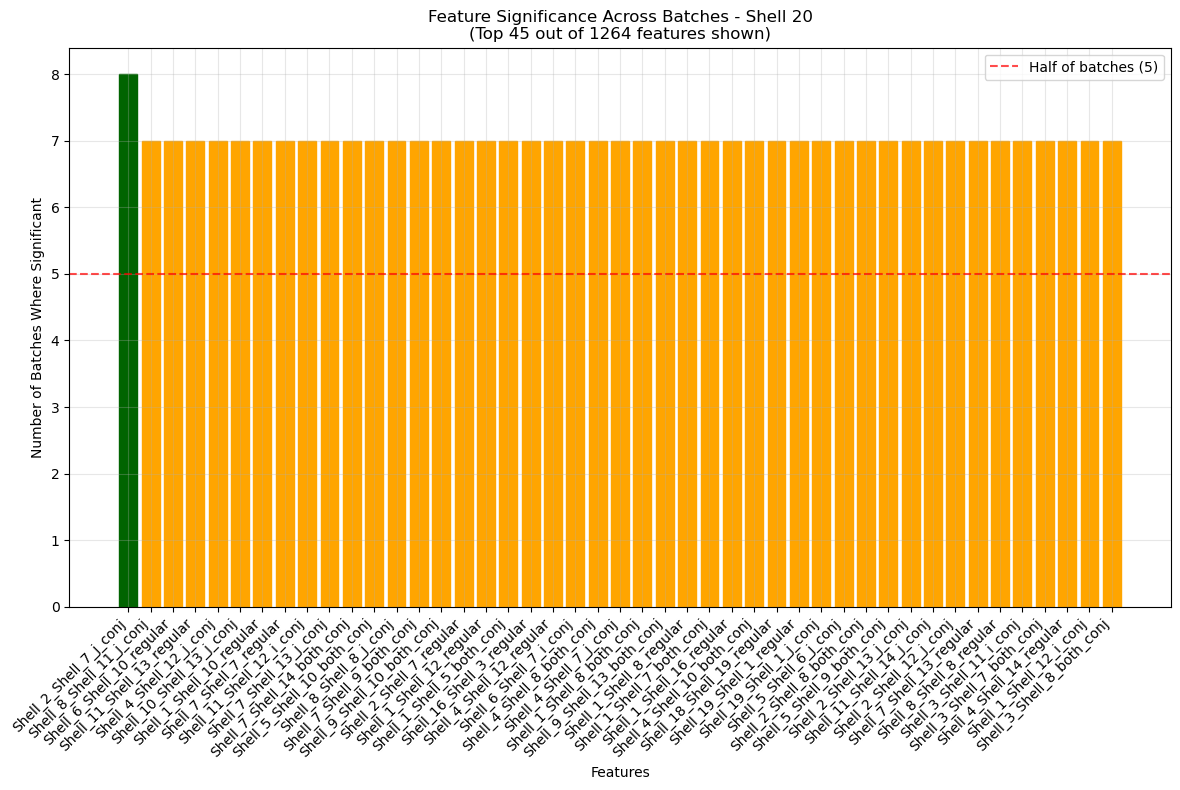

Partial W matrices saved to: Ws_CV/W_partial_shell20_nbatch10_tstart1_tend50000_allintTrue_iTrue_subtractDTrue_knormFalse_lassoCVTrue_lambda500.0_randombatchTrue_sigthresh100.0_minocc9.npy
Lambda values saved to: Ws_CV/lambda_partial_shell20_nbatch10_tstart1_tend50000_allintTrue_iTrue_subtractDTrue_knormFalse_lassoCVTrue_lambda500.0_randombatchTrue_sigthresh100.0_minocc9.npy
Final W matrix saved to: Ws_CV/W_final_shell20_nbatch10_tstart1_tend50000_allintTrue_iTrue_subtractDTrue_knormFalse_lassoCVTrue_lambda500.0_randombatchTrue_sigthresh100.0_minocc9.npy

Summary for Shell 20:
Total batches: 10
Minimum occurrences for inclusion: 9
Features in final W: 0

Significant features (sorted by absolute coefficient):
Top 0 interactions:

Expected interactions found in top 5: 0/2


In [28]:



subtract_dissipation_options = [True]
normalize_by_k_options = [False]
shell_idx_options = [19]  # Assuming 20 shells
n_batches_min_occ_options= [[10,9]]  # Different batch sizes to test

param_combinations = list(product(subtract_dissipation_options, normalize_by_k_options, shell_idx_options, n_batches_min_occ_options))
total_combinations = len(param_combinations)


LAM=2
AA=1
BB=AA/LAM-AA
CC=-AA/LAM
beta = 0.01
eps = 1
t_start = 1
t_end = 50000
nu = 1e-8
dt = beta * np.sqrt(nu / eps)
nn = 20
spectra_path = f"/home/vale/SABRA/params_bin/sim_nn{nn}_LAM_2_nu1e8/Spectra_complex"
forcing_path = f"/home/vale/SABRA/params_bin/sim_nn{nn}_LAM_2_nu1e8/Forcing_complex"
include_i = True  # Include self-interactions
use_lassoCV = True
lambda_reg = 5e2
k = 2.0 ** np.arange(nn)
random_batches = True  # Use sequential batches
significance_threshold = 1e2  # Threshold for significant coefficients
n_batches = 5  # Number of batches to use for cross-validation
min_occurrences = 5  # Minimum occurrences for a feature to be included in final W  # Include dissipation if not subtracting it
max_display = 45  # Maximum number of features to display in significance plot
expected = get_expected_interactions(nn)


for i, (subtract_dissipation, normalize_by_k, shell_idx, [n_batches,min_occurrences]) in enumerate(param_combinations):



    results= run_complete_batch_analysis(
        spectra_path, forcing_path, t_start_min=t_start, t_end=t_end, n_batches=n_batches, shell_idx=shell_idx,
        dt=dt, nu=nu, k=k, use_all_interactions=True, include_i=include_i,
        subtract_dissipation=subtract_dissipation, normalize_by_k=normalize_by_k,
        use_lassoCV=use_lassoCV, lambda_reg=lambda_reg,
        min_occurrences=min_occurrences, significance_threshold=significance_threshold,
        random_batches=random_batches, save_results=True, max_display=max_display
    )

    base_filename = f"shell{shell_idx+1}_nbatch{n_batches}_tstart{t_start}_tend{t_end}"
    base_filename += f"_allint{True}_i{include_i}"  # True for use_all_interactions since it's used in other cells
    base_filename += f"_subtractD{subtract_dissipation}_knorm{normalize_by_k}"
    base_filename += f"_lassoCV{use_lassoCV}_lambda{lambda_reg}"
    base_filename += f"_randombatch{random_batches}_sigthresh{significance_threshold}"
    base_filename += f"_minocc{min_occurrences}"
    include_dissipation = not subtract_dissipation  # Include dissipation if not subtracting it






    threshold2=1e3
    coupled = False  # Set to True if W contains coefficients for all shells learned together
    W_final= np.load(f"Ws_CV/W_final_{base_filename}.npy")
    top_n=30

    significant=analyze_interactions(
        W_final, nn=nn, use_all_interactions=True, threshold=threshold2, 
        expected_interactions=get_expected_interactions(nn), shell_idx=shell_idx, 
        include_dissipation=include_dissipation, coupled=coupled
    )





    # Sort interactions by magnitude before plotting
    sorted_interactions = sorted(significant, key=lambda x: abs(x['weight']), reverse=True)
    top_n = min(top_n, len(sorted_interactions))
    top_interactions = sorted_interactions[:top_n]

    labels = []
    for s in top_interactions:
        if s['term_type'] == 'dissipation':
            labels.append(f"D{s['i']}")
        else:
            labels.append(f"{s['i']}-{s['j']}:{s['type']}")
            
    magnitudes = [abs(s['weight']) for s in top_interactions]
    colors = ['red' if s['term_type'] == 'dissipation' else 'green' if s['highlight'] else  'gray' 
                for s in top_interactions]

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.bar(range(top_n), magnitudes, color=colors)
    plt.xticks(range(top_n), labels, rotation=45, ha='right')
    plt.ylabel('Magnitude of coefficient')

    if shell_idx is None:
        title = f'Top {top_n} Significant Interactions for All Shells'
    else:
        title = f'Top {top_n} Significant Interactions for Shell {shell_idx + 1}'

    if normalize_by_k:
        title += ' (Normalized by k_n)'

    plt.title(title)
        
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='green', label='Expected'),
                        Patch(facecolor='gray', label='Unexpected'),
                        Patch(facecolor='red', label='Dissipation')]
    plt.legend(handles=legend_elements)

    plt.tight_layout()

    # Save plot
    plt.savefig(f"Nonlinear_reg_figures_CV/interactions_bins_{base_filename}.png")
    plt.close()


    expected = get_expected_interactions(20)
    cmap= 'binary'  # Choose a colormap from the list above
    beta = 0.01
    eps = 1
    t_start = 1
    t_end = 50000
    nu = 1e-8
    dt = beta * np.sqrt(nu / eps)
    nn = 20
    spectra_path = f"/home/vale/SABRA/params_bin/sim_nn{nn}_LAM_2_nu1e8/Spectra_complex"
    forcing_path = f"/home/vale/SABRA/params_bin/sim_nn{nn}_LAM_2_nu1e8/Forcing_complex"
    include_i = True  # Include self-interactions
    use_lassoCV = True
    lambda_reg = 5e2
    k = 2.0 ** np.arange(nn)
    top_n_start=40
    top_n_end=60
    threshold2= 5e3  # Threshold for significant interactions
    min_necessary_samples = 50  # Define the maximum number of elements to include
    use_lassoCV = True  # Use LassoCV for automatic regularization selection
    lambda_reg = 5e2  # Regularization parameter for Lasso regression
    subtract_dissipation = True  # Whether to subtract dissipation from target
    normalize_by_k = True  # Normalize each equation by its corresponding k_n
    impose_symmetry = True  # Impose symmetry on the interaction matrix
    expected_shells = [shell_idx]
    top_n=5

    
    plot_suffix=base_filename


    plot_coupled_results(W_final, nn=nn, expected_shells=expected_shells, use_all_interactions=True, include_dissipation=include_dissipation,
                            top_n=top_n, threshold=threshold2, output_dir="Nonlinear_reg_figures_CV", save_plots=True,
                            plot_suffix=plot_suffix, impose_symmetry=impose_symmetry)




In [ ]:



subtract_dissipation_options = [True]
normalize_by_k_options = [False]
shell_idx_options = list(range(20))  # Assuming 20 shells
n_batches_min_occ_options= [[5,5],[10,9]]  # Different batch sizes to test

param_combinations = list(product(subtract_dissipation_options, normalize_by_k_options, shell_idx_options))
total_combinations = len(param_combinations)




LAM=2
AA=1
BB=AA/LAM-AA
CC=-AA/LAM
beta = 0.01
eps = 1
t_start = 1
t_end = 50000
nu = 1e-8
dt = beta * np.sqrt(nu / eps)
nn = 20
spectra_path = f"/home/vale/SABRA/params_bin/sim_nn{nn}_LAM_2_nu1e8/Spectra_complex"
forcing_path = f"/home/vale/SABRA/params_bin/sim_nn{nn}_LAM_2_nu1e8/Forcing_complex"
include_i = True  # Include self-interactions
lambda_reg = 5e2
k = 2.0 ** np.arange(nn)
random_batches = False  # Use sequential batches
significance_threshold = 1e2  # Threshold for significant coefficients
n_batches = 5  # Number of batches to use for cross-validation
min_occurrences = 5  # Minimum occurrences for a feature to be included in final W
include_dissipation = not subtract_dissipation  # Include dissipation if not subtracting it
max_display = 45  # Maximum number of features to display in significance plot
expected= get_expected_interactions(20)


for i, (subtract_dissipation, normalize_by_k, shell_idx, [n_batches,min_occurrences]) in enumerate(param_combinations):

    results= run_complete_batch_analysis(
        spectra_path, forcing_path, t_start_min=t_start, t_end=t_end, n_batches=n_batches, shell_idx=shell_idx,
        dt=dt, nu=nu, k=k, use_all_interactions=True, include_i=include_i,
        subtract_dissipation=subtract_dissipation, normalize_by_k=normalize_by_k,
        use_lassoCV=use_lassoCV, lambda_reg=lambda_reg,
        min_occurrences=min_occurrences, significance_threshold=significance_threshold,
        random_batches=random_batches, save_results=True, max_display=max_display
    )



    # Print expected interactions for shell_idx, including expected coefficient values

    print(f"\nExpected interactions for shell :{shell_idx+1}")
    for i, j, type_name in expected[shell_idx]:
        # Compute expected value based on SABRA model coefficients
        # i, j are 0-based indices
        if type_name == 'i_conj':
            # Forward-forward or backward-forward
            if (i == shell_idx + 1 and j == shell_idx + 2):  # i = n+1, j = n+2
                coeff = 1j * (2.0 ** (shell_idx + 2)) * AA
            elif (i == shell_idx - 1 and j == shell_idx + 1):  # i = n-1, j = n+1
                coeff = 1j * (2.0 ** (shell_idx + 1)) * BB
            else:
                coeff = None
        elif type_name == 'j_conj':
            # Symmetric to i_conj
            if (i == shell_idx + 2 and j == shell_idx + 1):  # i = n+2, j = n+1
                coeff = 1j * (2.0 ** (shell_idx + 2)) * AA
            elif (i == shell_idx + 1 and j == shell_idx - 1):  # i = n+1, j = n-1
                coeff = 1j * (2.0 ** (shell_idx + 1)) * BB
            else:
                coeff = None
        elif type_name == 'regular':
            # Backward-backward
            if (i == shell_idx - 2 and j == shell_idx - 1) or (i == shell_idx - 1 and j == shell_idx - 2):
                coeff = -1j * (2.0 ** (shell_idx)) * CC
            else:
                coeff = None
        else:
            coeff = None

        if coeff is not None:
            print(f"Shells ({i+1},{j+1}) Type: {type_name} | Expected coefficient: {coeff}")
        else:
            print(f"Shells ({i+1},{j+1}) Type: {type_name} | Expected coefficient: N/A")







    threshold2=1e3
    coupled = False  # Set to True if W contains coefficients for all shells learned together
    W_final= results['final_W']
    top_n=30
    shell_idx=15

    significant=analyze_interactions(
        W_final, nn=nn, use_all_interactions=True, threshold=threshold2, 
        expected_interactions=get_expected_interactions(nn), shell_idx=shell_idx, 
        include_dissipation=include_dissipation, coupled=coupled
    )





    # Sort interactions by magnitude before plotting
    sorted_interactions = sorted(significant, key=lambda x: abs(x['weight']), reverse=True)
    top_n = min(top_n, len(sorted_interactions))
    top_interactions = sorted_interactions[:top_n]

    labels = []
    for s in top_interactions:
        if s['term_type'] == 'dissipation':
            labels.append(f"D{s['i']}")
        else:
            labels.append(f"{s['i']}-{s['j']}:{s['type']}")
            
    magnitudes = [abs(s['weight']) for s in top_interactions]
    colors = ['red' if s['term_type'] == 'dissipation' else 'green' if s['highlight'] else  'gray' 
                for s in top_interactions]

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.bar(range(top_n), magnitudes, color=colors)
    plt.xticks(range(top_n), labels, rotation=45, ha='right')
    plt.ylabel('Magnitude of coefficient')

    if shell_idx is None:
        title = f'Top {top_n} Significant Interactions for All Shells'
    else:
        title = f'Top {top_n} Significant Interactions for Shell {shell_idx + 1}'

    if normalize_by_k:
        title += ' (Normalized by k_n)'

    plt.title(title)
        
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='green', label='Expected'),
                        Patch(facecolor='gray', label='Unexpected'),
                        Patch(facecolor='red', label='Dissipation')]
    plt.legend(handles=legend_elements)

    plt.tight_layout()
    plt.show()





    expected = get_expected_interactions(20)
    cmap= 'binary'  # Choose a colormap from the list above
    beta = 0.01
    eps = 1
    t_start = 1
    t_end = 50000
    nu = 1e-8
    dt = beta * np.sqrt(nu / eps)
    nn = 20
    spectra_path = f"/home/vale/SABRA/params_bin/sim_nn{nn}_LAM_2_nu1e8/Spectra_complex"
    forcing_path = f"/home/vale/SABRA/params_bin/sim_nn{nn}_LAM_2_nu1e8/Forcing_complex"
    include_i = True  # Include self-interactions
    use_lassoCV = True
    lambda_reg = 5e2
    k = 2.0 ** np.arange(nn)
    top_n_start=40
    top_n_end=60
    nn=20
    shell_idx= 15
    threshold2= 5e3  # Threshold for significant interactions
    min_necessary_samples = 50  # Define the maximum number of elements to include
    use_lassoCV = True  # Use LassoCV for automatic regularization selection
    lambda_reg = 5e2  # Regularization parameter for Lasso regression
    subtract_dissipation = True  # Whether to subtract dissipation from target
    normalize_by_k = True  # Normalize each equation by its corresponding k_n
    impose_symmetry = True  # Impose symmetry on the interaction matrix
    expected_shells = [shell_idx]
    top_n=5

    base_filename = f"shell{shell_idx+1}_nbatch{n_batches}_tstart{t_start}_tend{t_end}"
    base_filename += f"_allint{True}_i{include_i}"  # True for use_all_interactions since it's used in other cells
    base_filename += f"_subtractD{subtract_dissipation}_knorm{normalize_by_k}"
    base_filename += f"_lassoCV{use_lassoCV}_lambda{lambda_reg}"
    base_filename += f"_randombatch{random_batches}_sigthresh{significance_threshold}"
    base_filename += f"_minocc{min_occurrences}"
    plot_suffix=base_filename


    plot_coupled_results(W_final, nn=nn, expected_shells=expected_shells, use_all_interactions=True, include_dissipation=include_dissipation,
                            top_n=top_n, threshold=threshold2, output_dir="Nonlinear_reg_figures_CV", save_plots=True,
                            plot_suffix=plot_suffix, impose_symmetry=impose_symmetry)




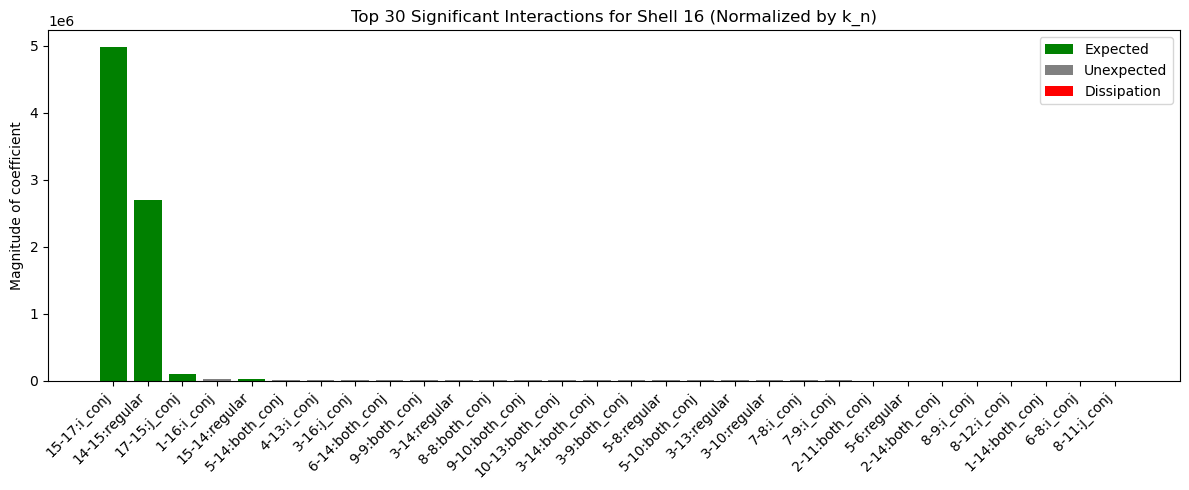

In [16]:

threshold2=1e3
coupled = False  # Set to True if W contains coefficients for all shells learned together
W_final= results['final_W']
top_n=30
shell_idx=15

significant=analyze_interactions(
    W_final, nn=nn, use_all_interactions=True, threshold=threshold2, 
    expected_interactions=get_expected_interactions(nn), shell_idx=shell_idx, 
    include_dissipation=include_dissipation, coupled=coupled
)





# Sort interactions by magnitude before plotting
sorted_interactions = sorted(significant, key=lambda x: abs(x['weight']), reverse=True)
top_n = min(top_n, len(sorted_interactions))
top_interactions = sorted_interactions[:top_n]

labels = []
for s in top_interactions:
    if s['term_type'] == 'dissipation':
        labels.append(f"D{s['i']}")
    else:
        labels.append(f"{s['i']}-{s['j']}:{s['type']}")
        
magnitudes = [abs(s['weight']) for s in top_interactions]
colors = ['red' if s['term_type'] == 'dissipation' else 'green' if s['highlight'] else  'gray' 
            for s in top_interactions]

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.bar(range(top_n), magnitudes, color=colors)
plt.xticks(range(top_n), labels, rotation=45, ha='right')
plt.ylabel('Magnitude of coefficient')

if shell_idx is None:
    title = f'Top {top_n} Significant Interactions for All Shells'
else:
    title = f'Top {top_n} Significant Interactions for Shell {shell_idx + 1}'

if normalize_by_k:
    title += ' (Normalized by k_n)'

plt.title(title)
    
# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', label='Expected'),
                    Patch(facecolor='gray', label='Unexpected'),
                    Patch(facecolor='red', label='Dissipation')]
plt.legend(handles=legend_elements)

plt.tight_layout()
plt.show()


In [ ]:

expected = get_expected_interactions(20)
cmap= 'binary'  # Choose a colormap from the list above
beta = 0.01
eps = 1
t_start = 1
t_end = 50000
nu = 1e-8
dt = beta * np.sqrt(nu / eps)
nn = 20
spectra_path = f"/home/vale/SABRA/params_bin/sim_nn{nn}_LAM_2_nu1e8/Spectra_complex"
forcing_path = f"/home/vale/SABRA/params_bin/sim_nn{nn}_LAM_2_nu1e8/Forcing_complex"
include_i = True  # Include self-interactions
use_lassoCV = True
lambda_reg = 5e2
k = 2.0 ** np.arange(nn)
top_n_start=40
top_n_end=60
nn=20
shell_idx= 15
threshold2= 5e3  # Threshold for significant interactions
min_necessary_samples = 50  # Define the maximum number of elements to include
use_lassoCV = True  # Use LassoCV for automatic regularization selection
lambda_reg = 5e2  # Regularization parameter for Lasso regression
subtract_dissipation = True  # Whether to subtract dissipation from target
normalize_by_k = True  # Normalize each equation by its corresponding k_n
impose_symmetry = True  # Impose symmetry on the interaction matrix
expected_shells = [shell_idx]
top_n=5

base_filename = f"shell{shell_idx+1}_nbatch{n_batches}_tstart{t_start}_tend{t_end}"
base_filename += f"_allint{True}_i{include_i}"  # True for use_all_interactions since it's used in other cells
base_filename += f"_subtractD{subtract_dissipation}_knorm{normalize_by_k}"
base_filename += f"_lassoCV{use_lassoCV}_lambda{lambda_reg}"
base_filename += f"_randombatch{random_batches}_sigthresh{significance_threshold}"
base_filename += f"_minocc{min_occurrences}"
plot_suffix=base_filename


plot_coupled_results(W_final, nn=nn, expected_shells=expected_shells, use_all_interactions=True, include_dissipation=include_dissipation,
                        top_n=top_n, threshold=threshold2, output_dir="Nonlinear_reg_figures_CV", save_plots=True,
                        plot_suffix=plot_suffix, impose_symmetry=impose_symmetry)

